<a href="https://colab.research.google.com/github/kuwaitikiwi/edgered-interview/blob/main/EdgeRed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fast')
palette = sns.color_palette(['#113D63', '#8DB4E2', '#D9D9D9', '#C3DFF9', '#C5504D','#F2F2F2'])

#making graphs look fancier
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.titleweight'] = 'bold'

clients = pd.read_csv('https://raw.githubusercontent.com/kuwaitikiwi/edgered-interview/main/Clients.csv')
df = pd.read_csv('https://raw.githubusercontent.com/kuwaitikiwi/edgered-interview/main/Payments.csv')
#assign the corresponding entity_type, entity_year_established for each client_id in each row of the raw dataframe
df['entity_type'] = df['client_id'].map(clients['entity_type'])
df['entity_year_established'] = df['client_id'].map(clients['entity_year_established'])

#transfrom the entity_year_established to a age of the entity by subtracting the year from this year
df['entity_year_established'] = dt.datetime.now().year - df['entity_year_established']
df['entity_year_established'] = df['entity_year_established'].astype('int')

#use datetime to convert the transaction_date to a date time object
df['transaction_date'] = df['transaction_date'].apply(lambda x: dt.datetime.fromtimestamp(x))

df['transaction_date'] = pd.to_datetime(df['transaction_date'], unit='s')
#df.set_index('transaction_date', inplace=True)

df.describe()

,transaction_id,contract_id,client_id,payment_amt,entity_year_established
count,25559.000000,25559.000000,25559.000000,25559.000000,25559.000000
mean,12780.000000,758.221409,602.886811,1221.455691,14.926249
std,7378.392101,352.190207,344.782295,4346.049363,5.692206
min,1.000000,1.000000,1.000000,-136.660000,6.000000
25%,6390.500000,510.000000,308.000000,93.330000,10.000000
50%,12780.000000,732.000000,593.000000,266.660000,14.000000
75%,19169.500000,991.000000,894.000000,833.330000,20.000000
max,25559.000000,1643.000000,1281.000000,200000.050000,25.000000


### Cleaning
- Assigned entity_type and entity_year_established to each transaction based on client_id
- Converted EPOCH time to human readable time
- Remove all entries with same column values except for transaction_id
- Removed outliers (> 95th percentile) in payment_amt, as it is clear there are outliers ($200000 compared to $4000 mean)

<Axes: >

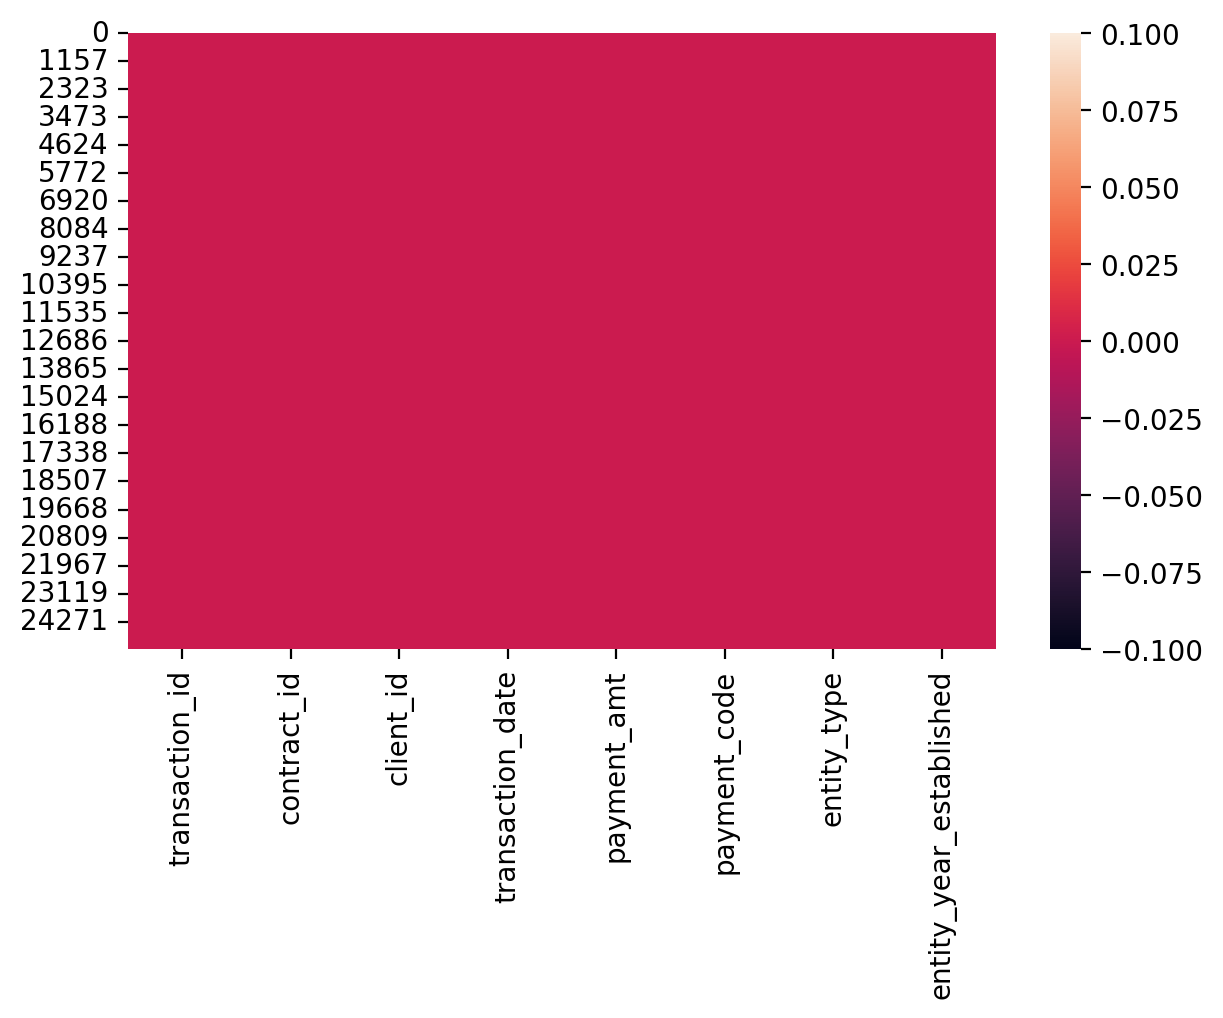

In [2]:
df = df.drop_duplicates(subset=['transaction_date','payment_amt','client_id','payment_code'])

df.drop(df[df['payment_amt']>df.payment_amt.quantile(0.95)].index, inplace=True)

df.dropna(inplace=True)
plt.figure(figsize=(7,4))
sns.heatmap(df.isnull(), cbar=True)


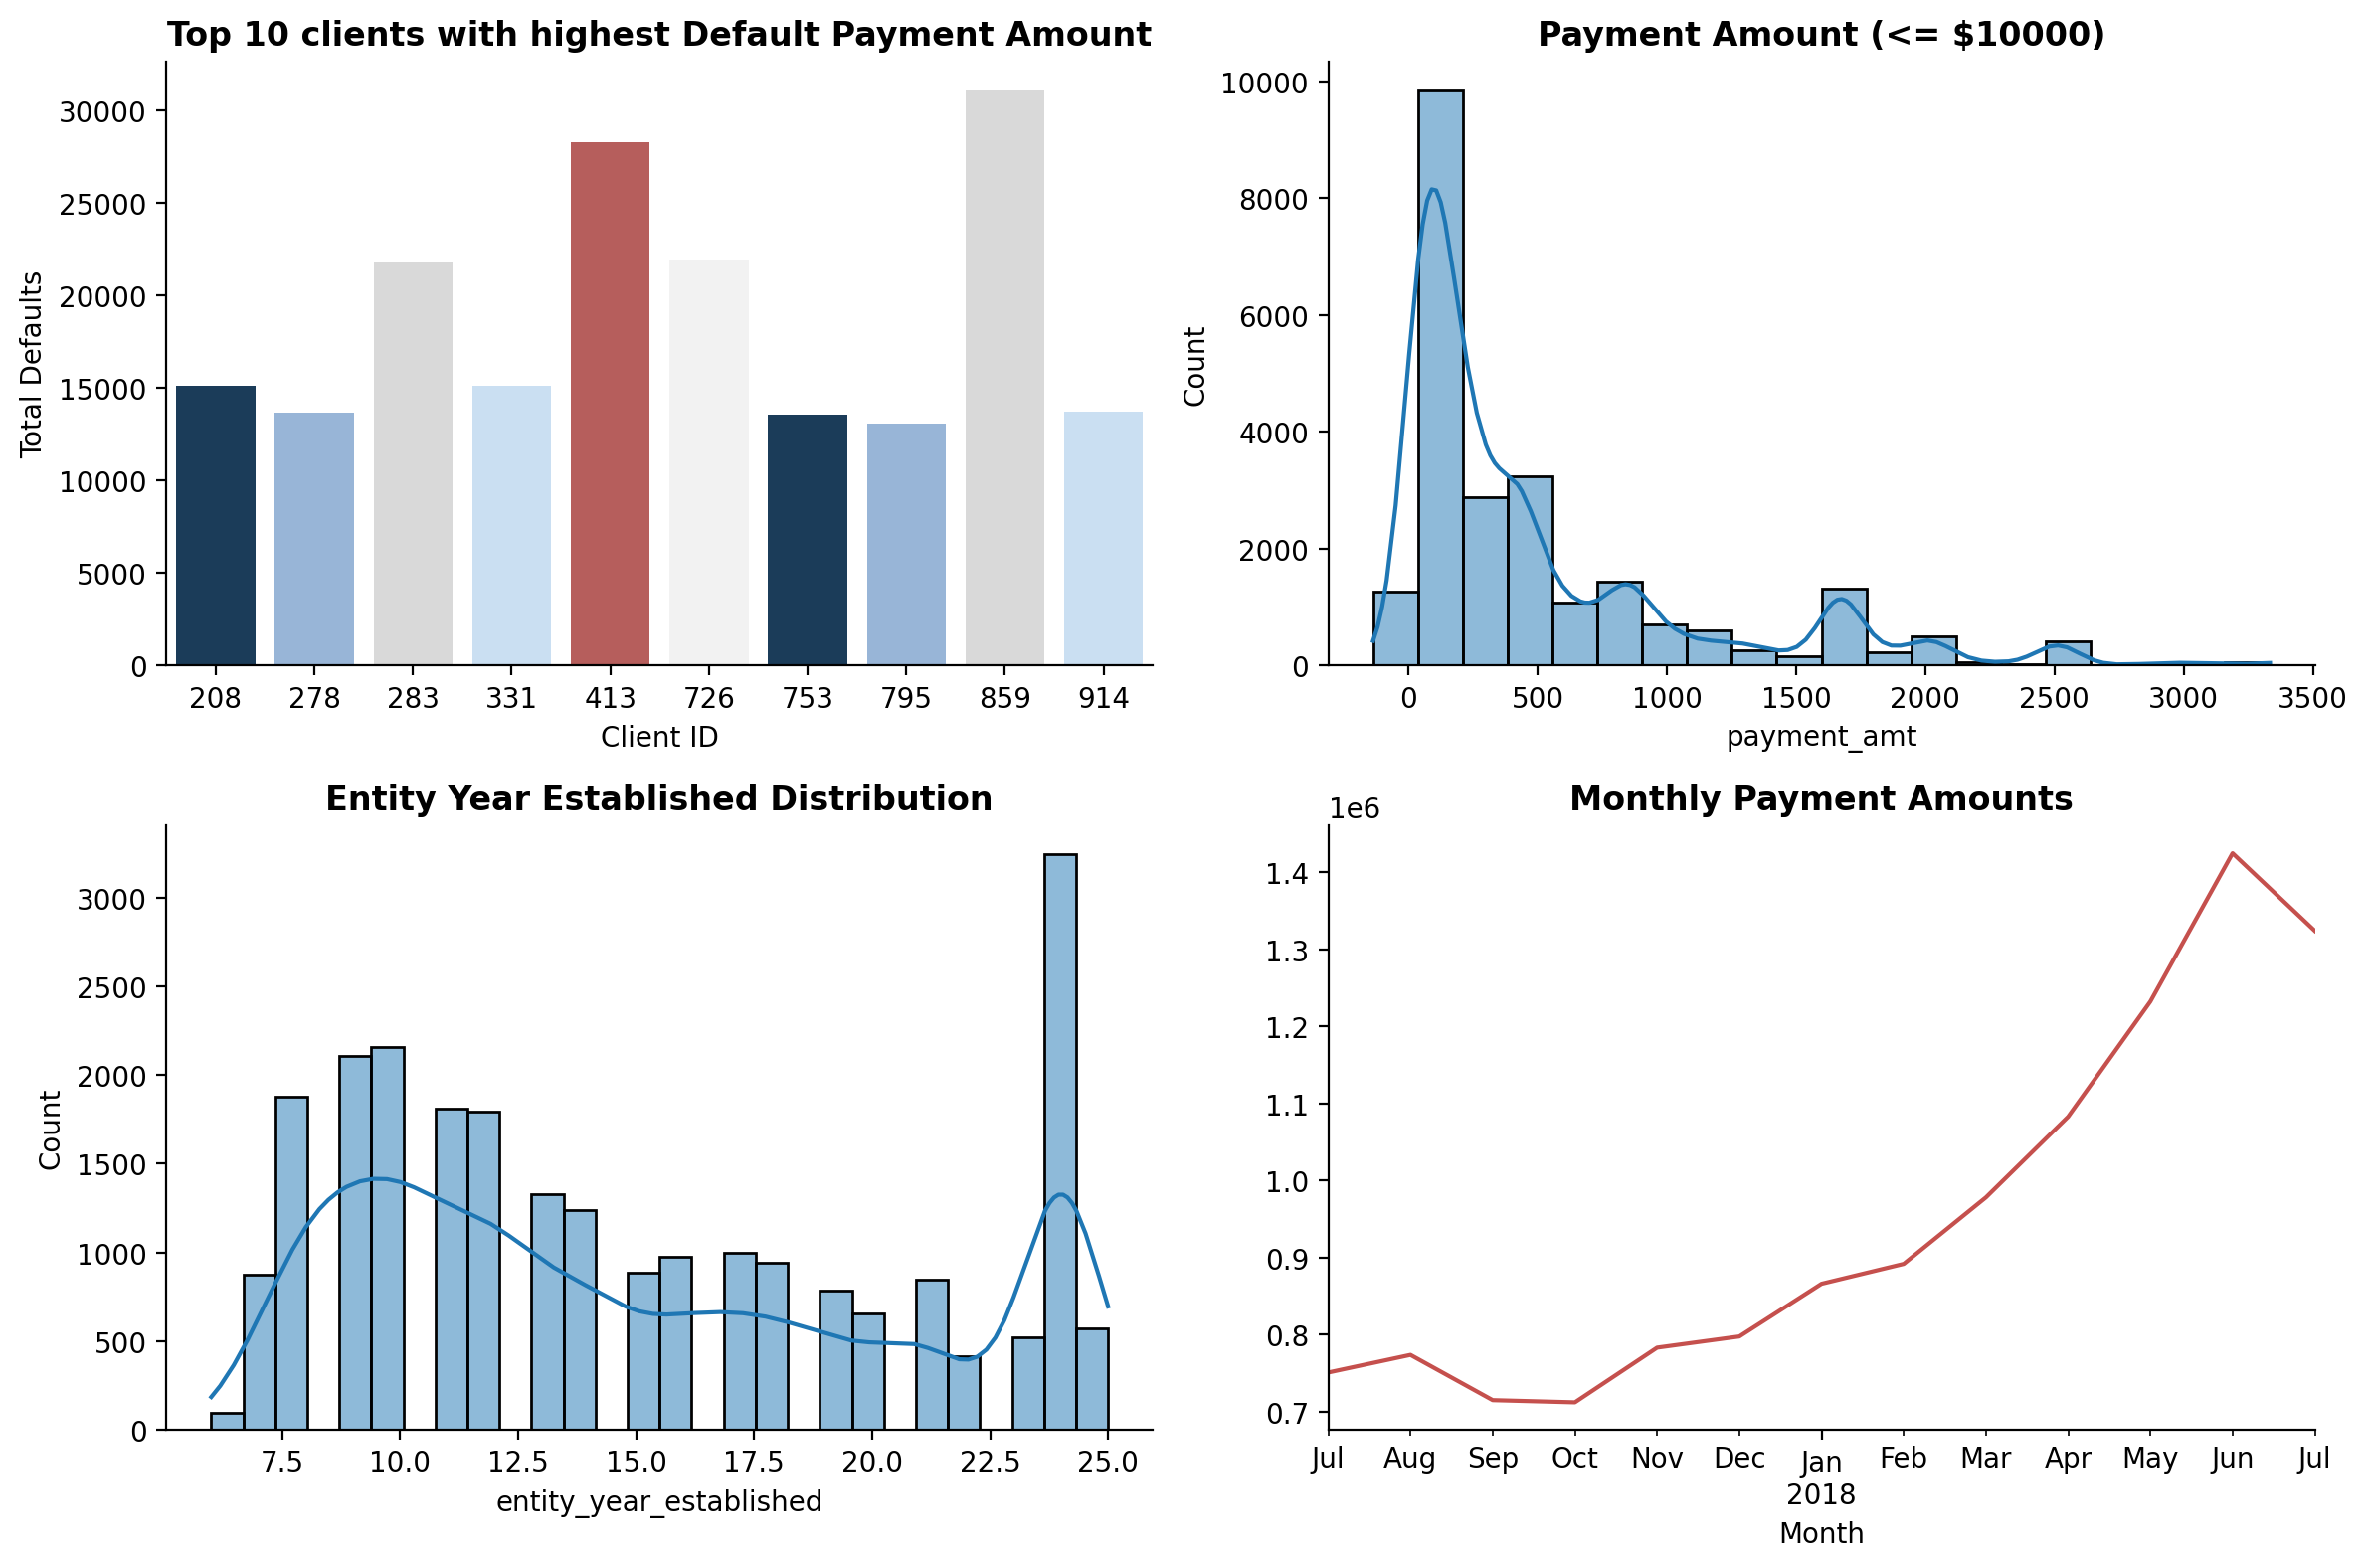

In [ ]:

fig, ax = plt.subplots(2,2, figsize=(12,8))
data = df[df['payment_code'] == 'DEFAULT'].groupby('client_id')['payment_amt'].sum().nlargest(10).reset_index()

sns.barplot(data=data, x='client_id', y='payment_amt', ax = ax[0,0], palette=palette)
ax[0,0].set_xlabel('Client ID')
ax[0,0].set_ylabel('Total Defaults')
ax[0,0].set_title('Top 10 clients with highest Default Payment Amount')

sns.histplot(df['entity_year_established'], kde=True, ax=ax[1, 0], palette=palette)
ax[1, 0].set_title('Entity Year Established Distribution')

sns.histplot(df[df.payment_amt <= 10000]['payment_amt'], kde=True, ax=ax[0, 1], palette=palette,bins = 20)
ax[0, 1].set_title('Payment Amount (<= $10000)')

data = df.copy()
data.set_index('transaction_date', inplace=True)
data['payment_amt'].resample('M').sum().plot(ax=ax[1, 1], color=palette[4])
ax[1, 1].set_title('Monthly Payment Amounts')
ax[1,1].set_xlabel('Month')

plt.tight_layout()
plt.show()


## EDA

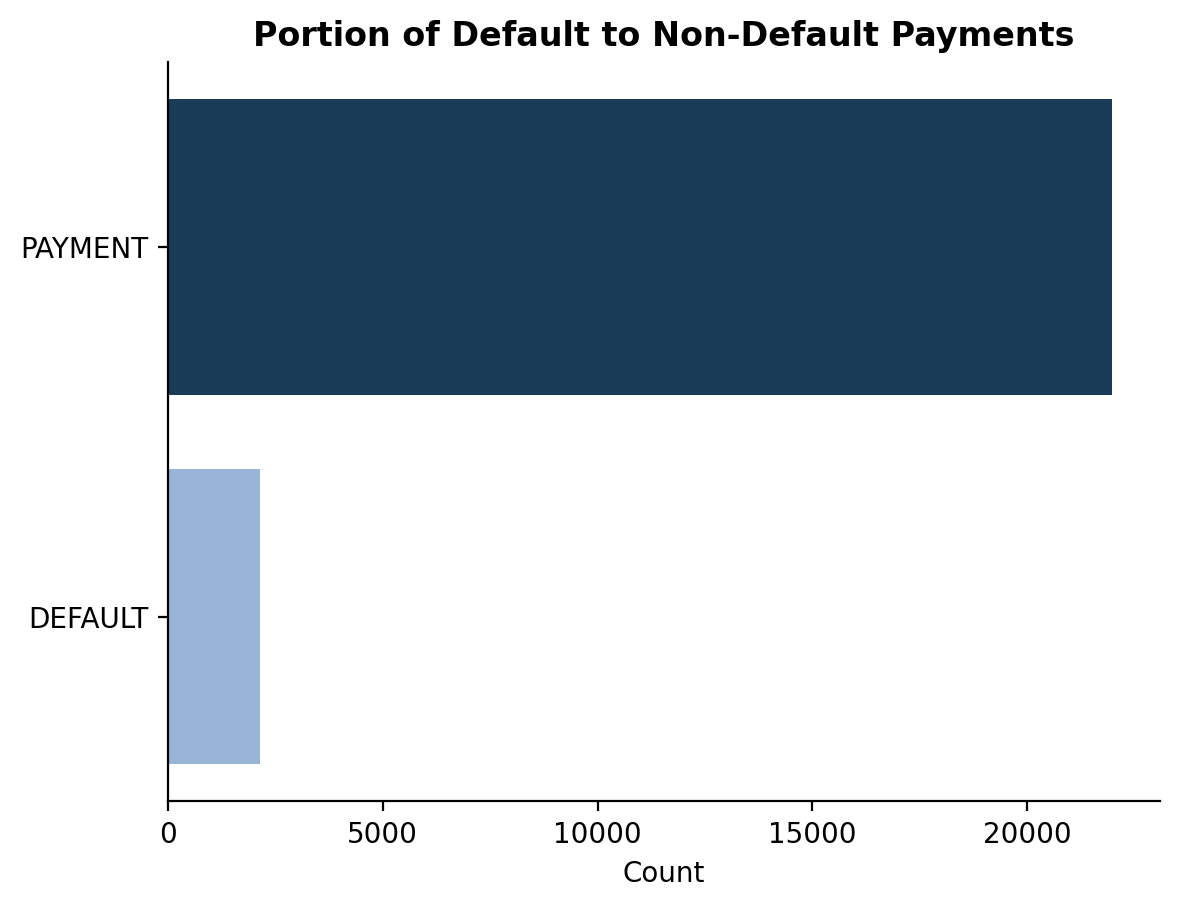

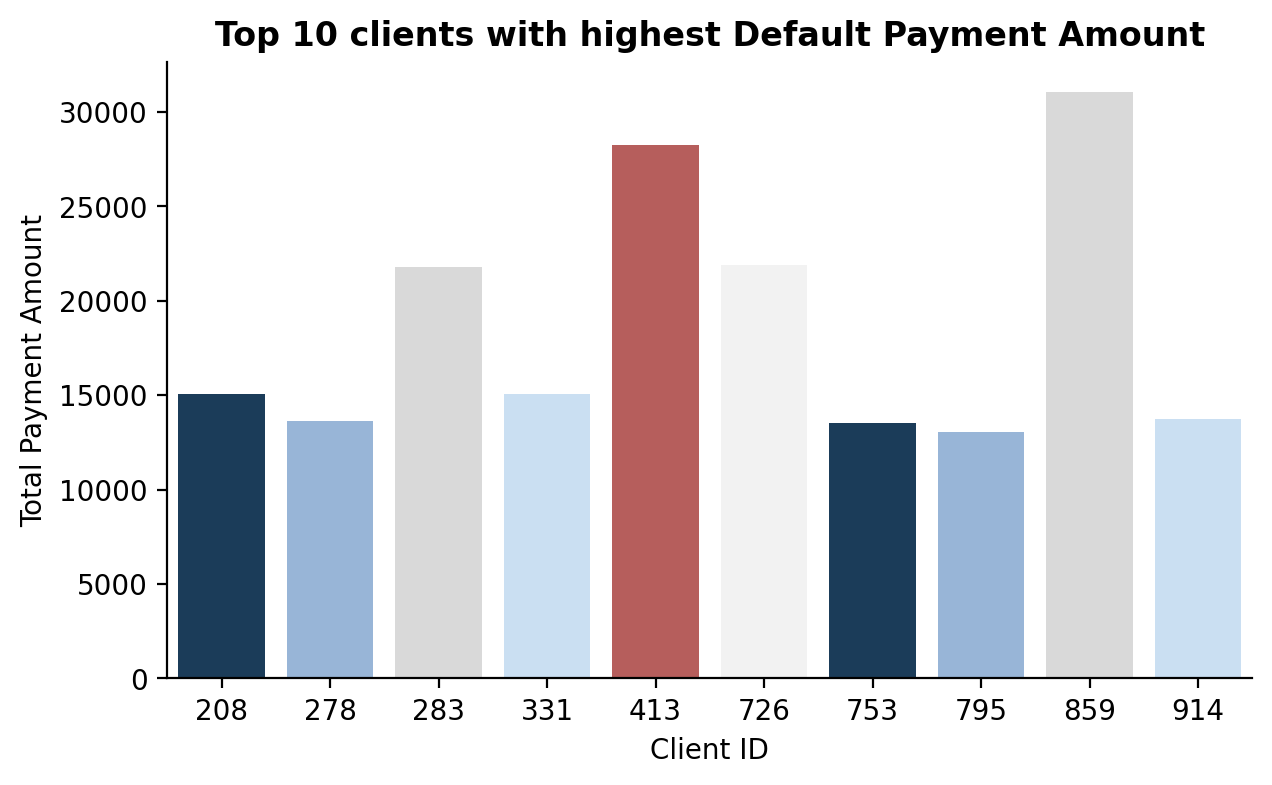

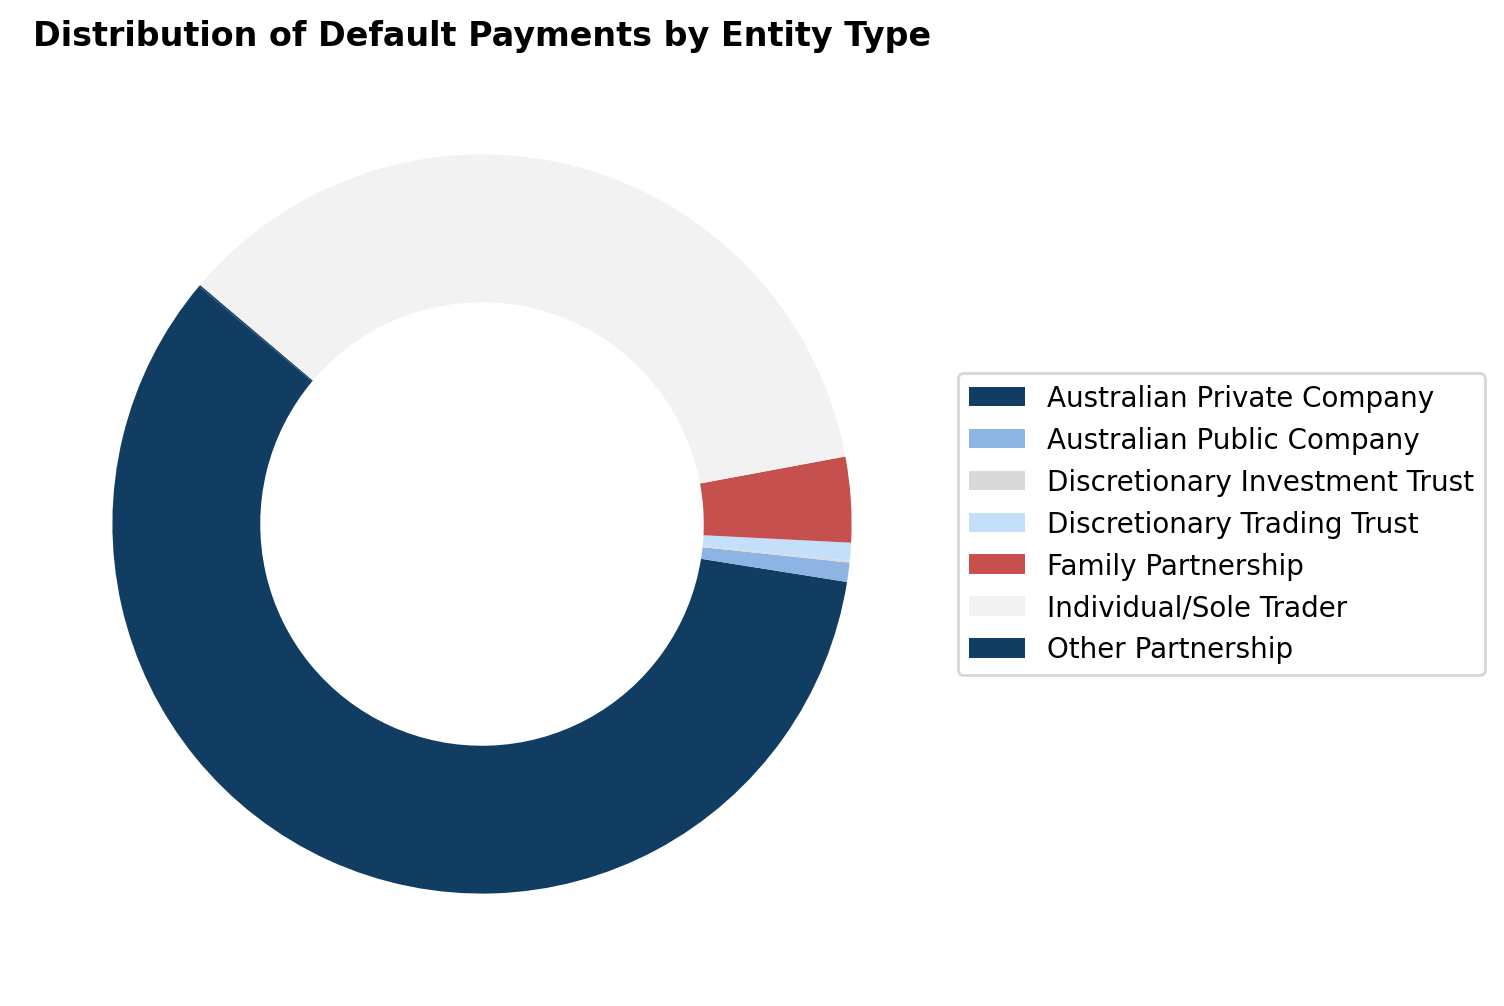

In [ ]:
sns.countplot(data=df, y='payment_code', palette=palette)
plt.title('Portion of Default to Non-Default Payments')
plt.ylabel('')
plt.xlabel('Count')
plt.show()

plt.figure(figsize=(7, 4))
data = df[df['payment_code'] == 'DEFAULT'].groupby('client_id')['payment_amt'].sum().nlargest(10).reset_index()
sns.barplot(data=data, x='client_id', y='payment_amt', palette=palette)
plt.xlabel('Client ID')
plt.ylabel('Total Payment Amount')
plt.title('Top 10 clients with highest Default Payment Amount')
plt.show()

plt.figure(figsize=(6,6))
data = df[df['payment_code'] == 'DEFAULT'].groupby('entity_type')['payment_amt'].sum().reset_index()
plt.pie(data['payment_amt'], labels=None, startangle=140, colors=sns.color_palette(palette), wedgeprops=dict(width=0.4))
plt.title('Distribution of Default Payments by Entity Type')

plt.legend(data['entity_type'], loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


### Payment Amount and Default
- From below we can observe that mean payment amount for defaults are lower than payments. This may be due to firms with lower payments being less financially viable and thus more likely to default.
- To determine if this is true, we will compare whether payment amount in default group is significantly lower than non-default groups.
- Depending on the distribution of payment amount, we will use either t-test or Mann-Whitney U test to compare the means of payment amount between default and non-default groups.
- $H_0: \mu_{\text{default}} = \mu_{\text{non-default}}$ $H_1: \mu_{\text{default}} < \mu_{\text{non-default}}$

In [ ]:
mean_amt = df.groupby('payment_code')['payment_amt'].mean()
mean_amt

payment_code
DEFAULT    481.189137
PAYMENT    514.156616
Name: payment_amt, dtype: float64

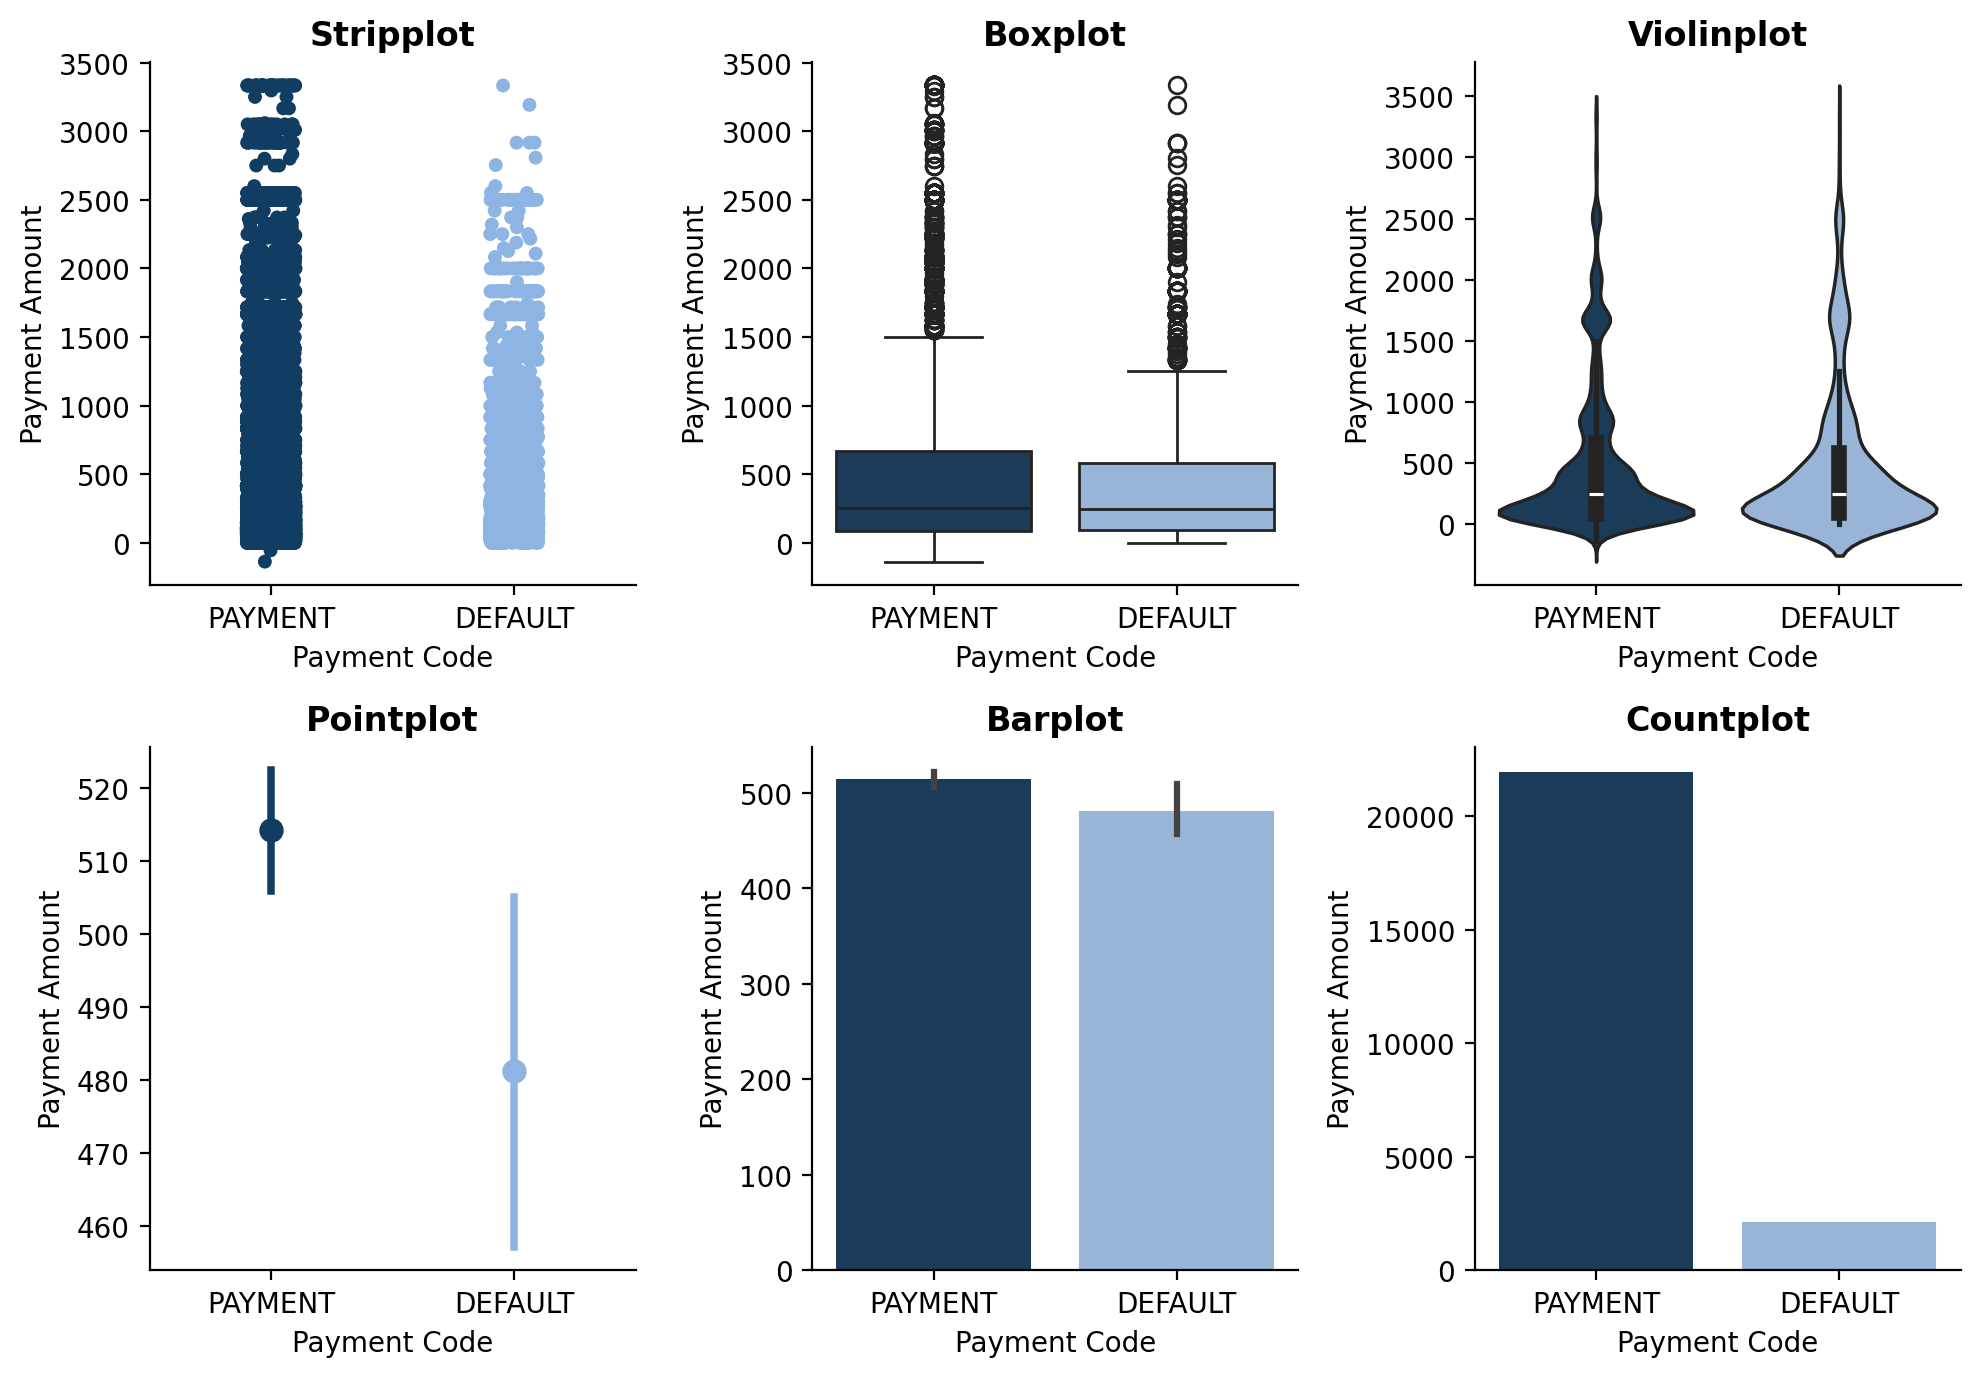

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7))

sns.stripplot(x="payment_code", y="payment_amt", data=df, ax=axs[0, 0],palette=palette)
axs[0, 0].set_title('Stripplot')

# distribution plots
sns.boxplot(x="payment_code", y="payment_amt", data=df, ax=axs[0, 1],palette=palette)
axs[0, 1].set_title('Boxplot')

sns.violinplot(x="payment_code", y="payment_amt", data=df, ax=axs[0, 2],palette=palette)
axs[0, 2].set_title('Violinplot')

# categorical estimate plots
sns.pointplot(x="payment_code", y="payment_amt", data=df, ax=axs[1, 0],palette=palette)
axs[1, 0].set_title('Pointplot')

sns.barplot(x="payment_code", y="payment_amt", data=df, ax=axs[1, 1],palette=palette)
axs[1, 1].set_title('Barplot')

sns.countplot(x="payment_code", data=df, ax=axs[1, 2],palette=palette)
axs[1, 2].set_title('Countplot')

for ax in axs.flat:
    ax.set_ylabel('Payment Amount')
    ax.set_xlabel('Payment Code')

plt.tight_layout()
plt.show()


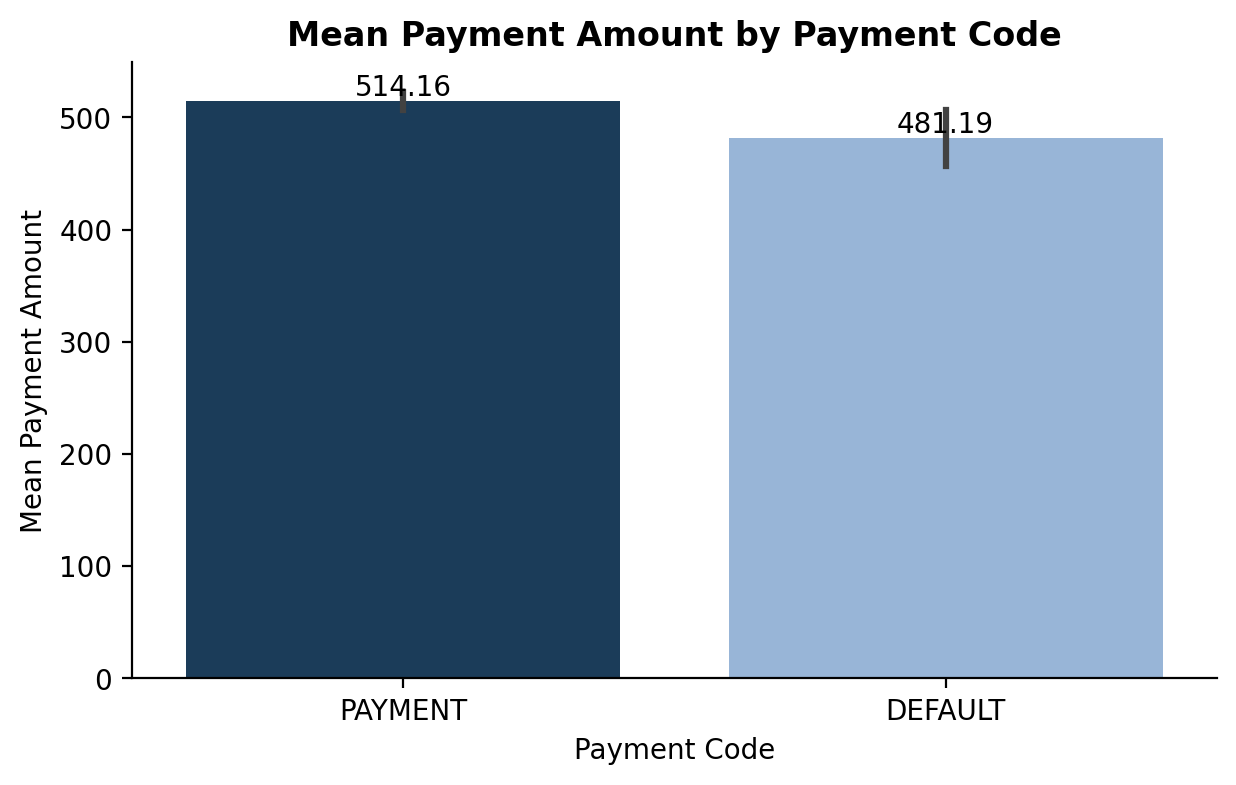

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(x="payment_code", y="payment_amt", data=df, palette=palette, ax=ax)
plt.xlabel('Payment Code')
plt.ylabel('Mean Payment Amount')
plt.title('Mean Payment Amount by Payment Code')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.show()

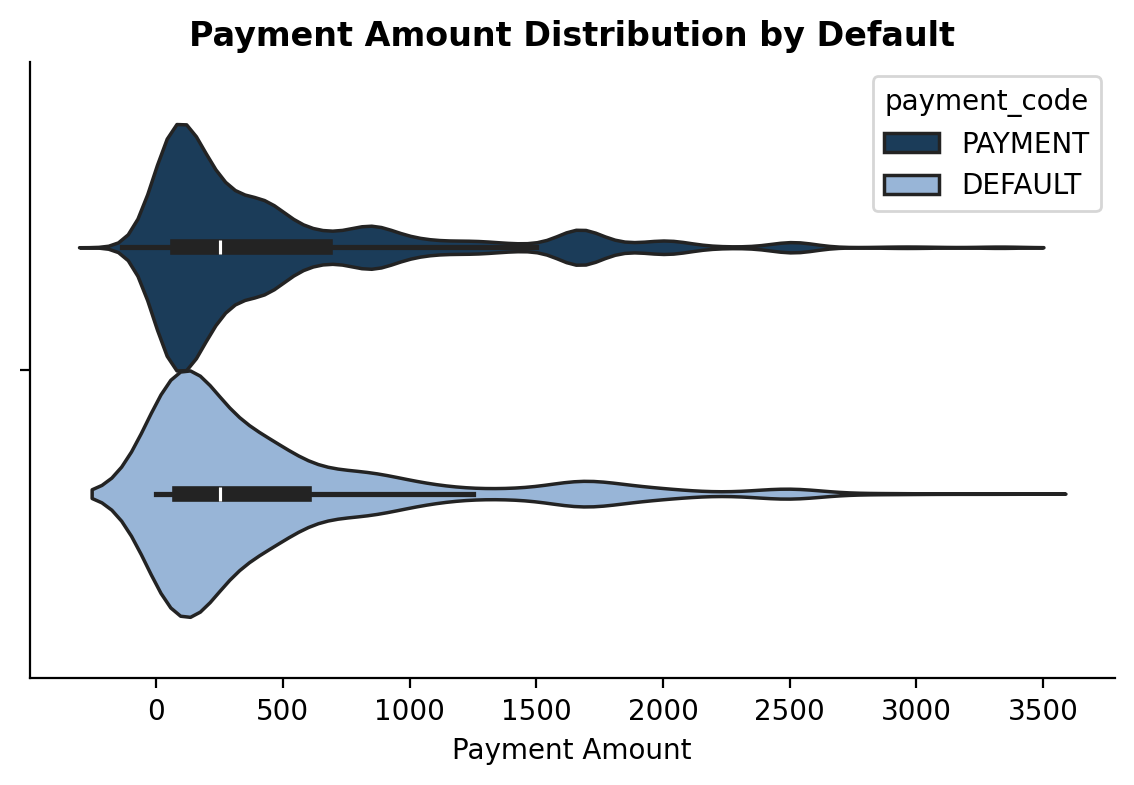

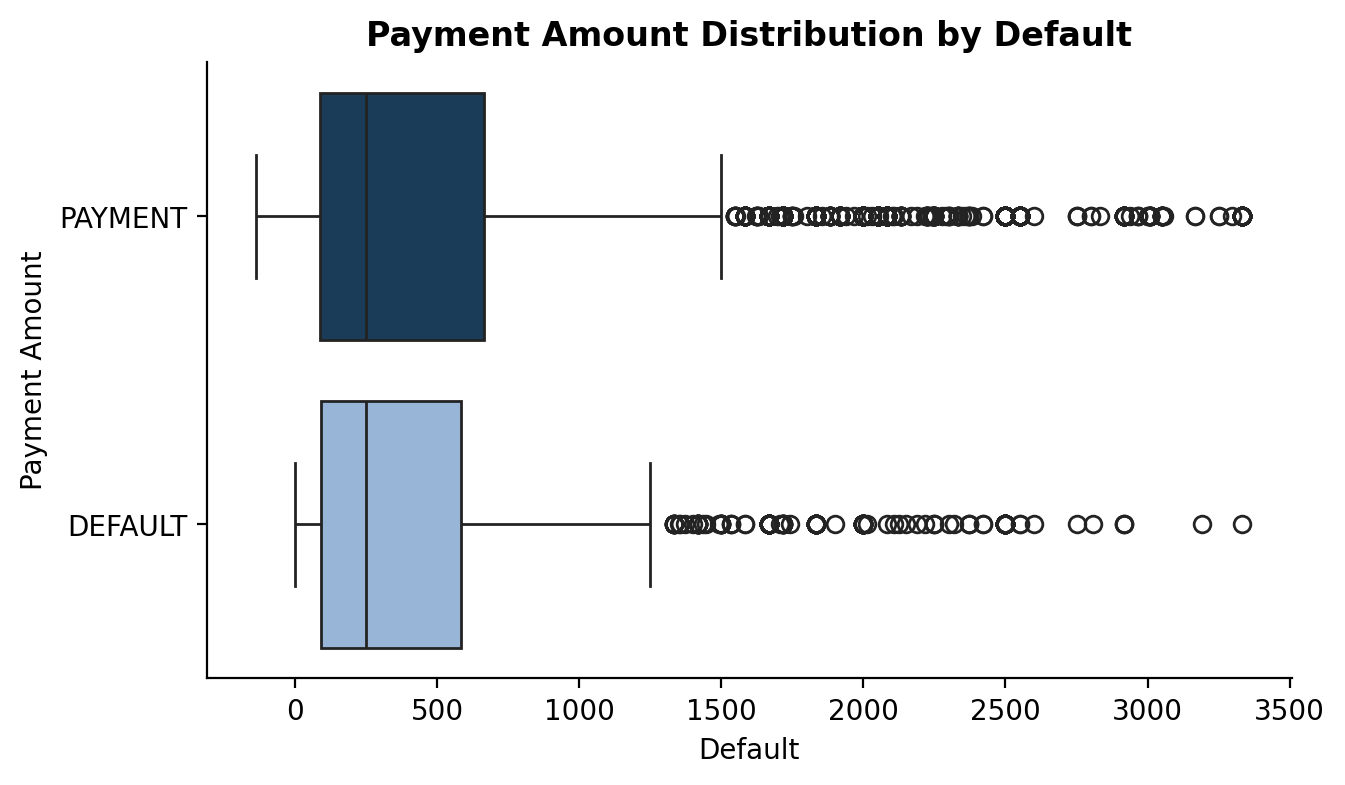

In [ ]:
df['payment_amt'] = df['payment_amt'].astype('float')


plt.figure(figsize=(7,4))
sns.violinplot(x='payment_amt', hue='payment_code', data=df,palette = palette,fill=True)
plt.title('Payment Amount Distribution by Default')
plt.xlabel('Payment Amount')
plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(x='payment_amt', y='payment_code', data=df, palette=palette)
plt.title('Payment Amount Distribution by Default')
plt.xlabel('Default')
plt.ylabel('Payment Amount')
plt.show()


In [ ]:
mean_amt = df.groupby('payment_code')['payment_amt'].mean().reset_index()
mean_amt = mean_amt.rename(columns={'payment_amt':'mean_payment_amt'})
mean_amt

,payment_code,mean_payment_amt
0,DEFAULT,481.189137
1,PAYMENT,514.156616


#### Assumption Checking
- Though its already very obvious from the QQplot, a Shapiro test for normality shows a p-value < 0.05, so we reject the null hypothesis that the data is normally distributed.
- T-test is not appropriate for non-normal data, so we will use the Mann-Whitney U test to determine whether payment amt of
- Distributions are roughly similar as observed from boxplot
-

Shapiro Statistics=0.752, p=0.000


<Figure size 300x300 with 0 Axes>

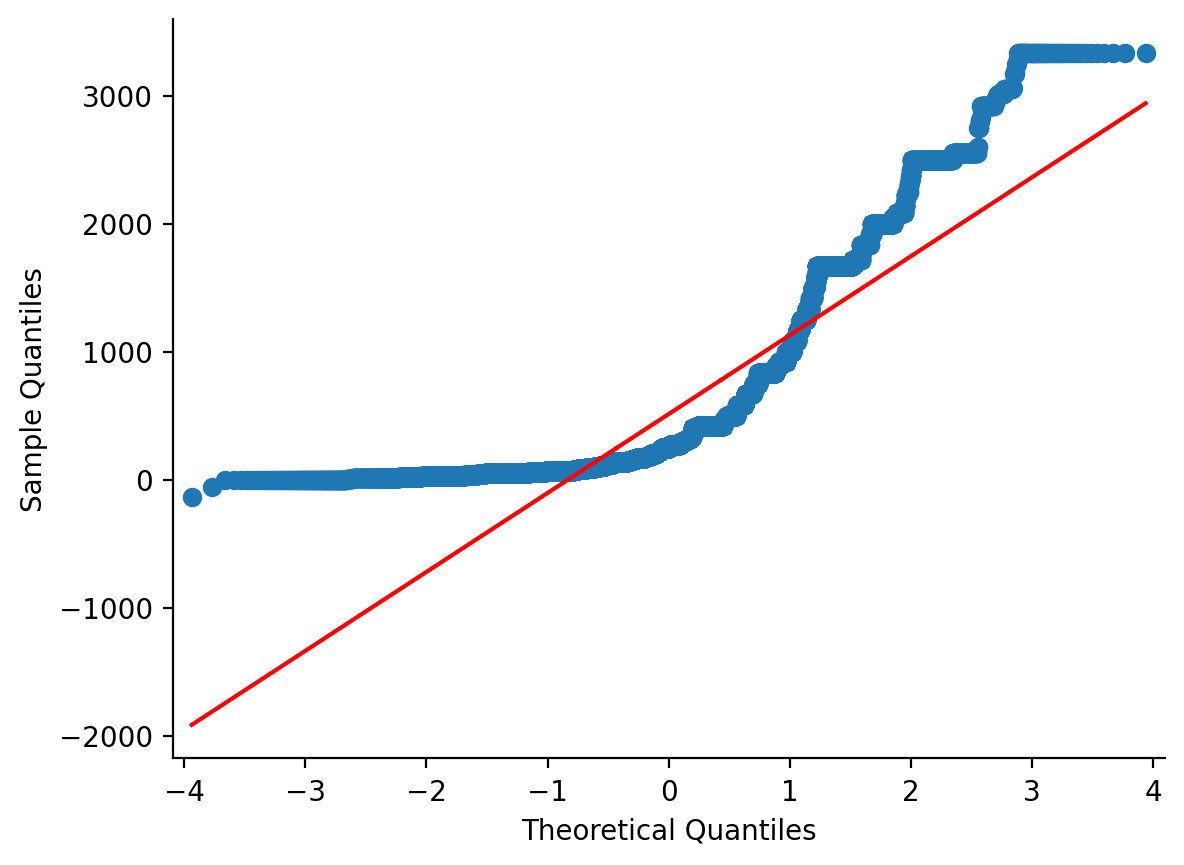

In [ ]:
#use Shapiro test to check for normality of payment_amt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
stat, p = shapiro(df['payment_amt'])
print('Shapiro Statistics=%.3f, p=%.3f' % (stat, p))
plt.figure(figsize=(3,3))
qqplot(df['payment_amt'], line='s')
plt.show()


In [ ]:
#use Mann-Whitney U test to check if the payment_amt is significantly higher for default payments
from scipy.stats import mannwhitneyu
x = df[df['payment_code'] == 'DEFAULT']['payment_amt']
y = df[df['payment_code'] == 'PAYMENT']['payment_amt']
stat, p = mannwhitneyu(x, y, alternative='less')
degrees_of_freedom = len(x) + len(y) - 2
print('Mann-Whitney U test Statistics=%.3f, p=%.3f, Degrees of Freedom=%d' % (stat, p, degrees_of_freedom))


Mann-Whitney U test Statistics=23044555.500, p=0.048, Degrees of Freedom=24116


### Entity Type

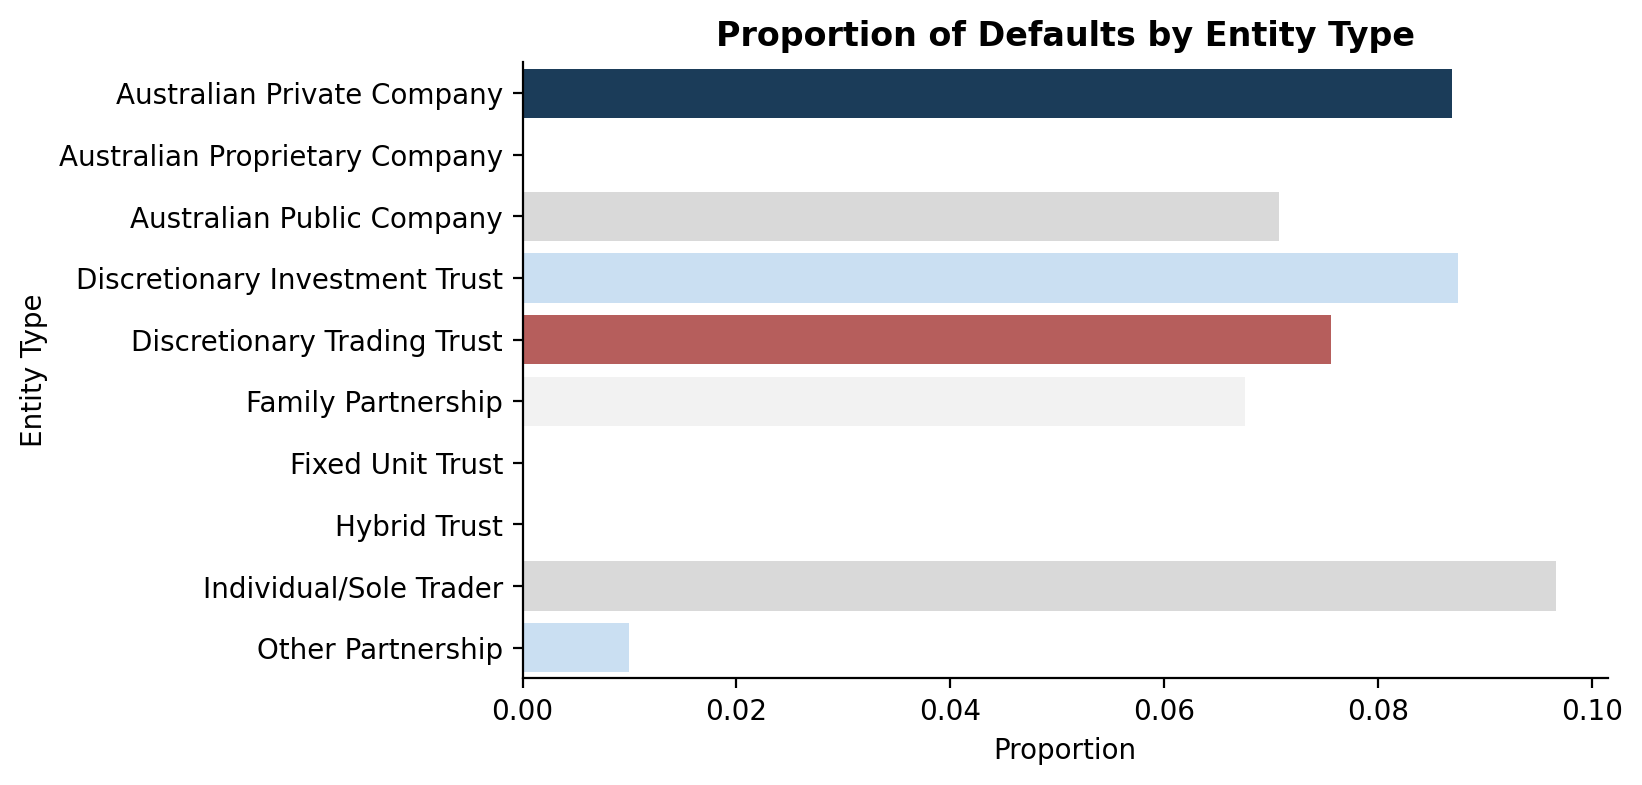

In [ ]:

default = df[df.payment_code=='DEFAULT']['entity_type'].value_counts()
total = df['entity_type'].value_counts()
proportion = default/total

plt.figure(figsize=(7,4))
sns.barplot(x=proportion.values, y=proportion.index,palette = palette)
plt.title('Proportion of Defaults by Entity Type')
plt.xlabel('Proportion')
plt.ylabel('Entity Type')
plt.show()

#### Chi-Square Test of Independence
- To determine whether entity type is a good predictor of default, we will use the chi-square test of independence to compare the distribution of entity type between default and non-default groups.
- As seen below, the initial contingency table contains expected counts of < 5, therefore Entity Types are re-categorized into Company, Partnership, Individual and Trust
- The test yields a p-value < 0.05, providing strong evidence to reject the null hypothesis that employment status and course option is independent.

In [ ]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['entity_type'], df['payment_code'])
contingency_table

payment_code,DEFAULT,PAYMENT
entity_type,,
Australian Private Company,1195,12547
Australian Proprietary Company,0,4
Australian Public Company,8,105
Discretionary Investment Trust,7,73
Discretionary Trading Trust,18,220
Family Partnership,49,676
Fixed Unit Trust,0,53
Hybrid Trust,0,13
Individual/Sole Trader,865,8085


In [ ]:
chisqdf = df.replace({
    'entity_type': {
        'Australian Private Company': 'Company',
        'Australian Proprietary Company': 'Company',
        'Australian Public Company': 'Company',
        'Discretionary Investment Trust': 'Trust',
        'Discretionary Trading Trust': 'Trust',
        'Fixed Unit Trust': 'Trust',
        'Hybrid Trust': 'Trust',
        'Family Partnership': 'Partnership',
        'Other Partnership': 'Partnership'
    }
})

contingency_table = pd.crosstab(chisqdf['payment_code'], chisqdf['entity_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print('Test Statistic:', chi2)
#print pvalue as percentage
print('p-value:', p*100)
print('Degrees of freedom:', dof)
contingency_table



Test Statistic: 23.0911881124264
p-value: 0.0038653643279345064
Degrees of freedom: 3


entity_type,Company,Individual/Sole Trader,Partnership,Trust
payment_code,,,,
DEFAULT,1203,865,51,25
PAYMENT,12656,8085,874,359


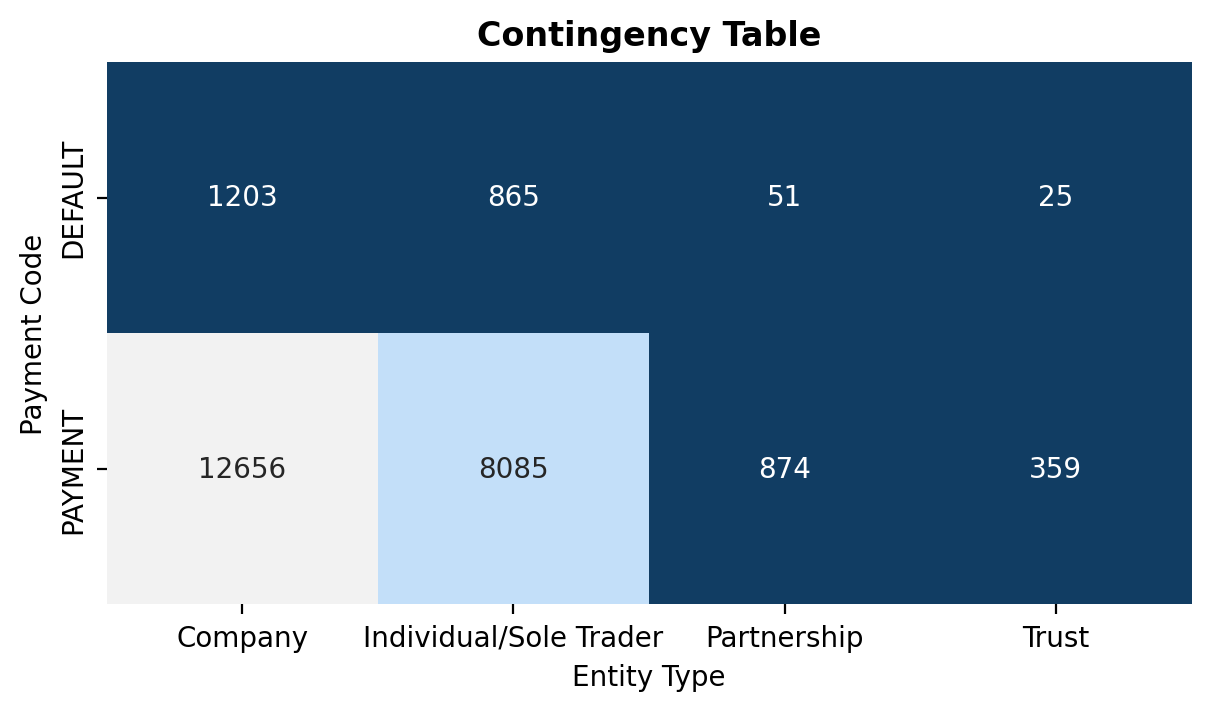

In [ ]:
#visualize contingency table
plt.figure(figsize=(7,4))
sns.heatmap(contingency_table, annot=True, cmap=palette, cbar=False, square=True, fmt='d')
plt.title('Contingency Table')
plt.xlabel('Entity Type')
plt.ylabel('Payment Code')
plt.show()

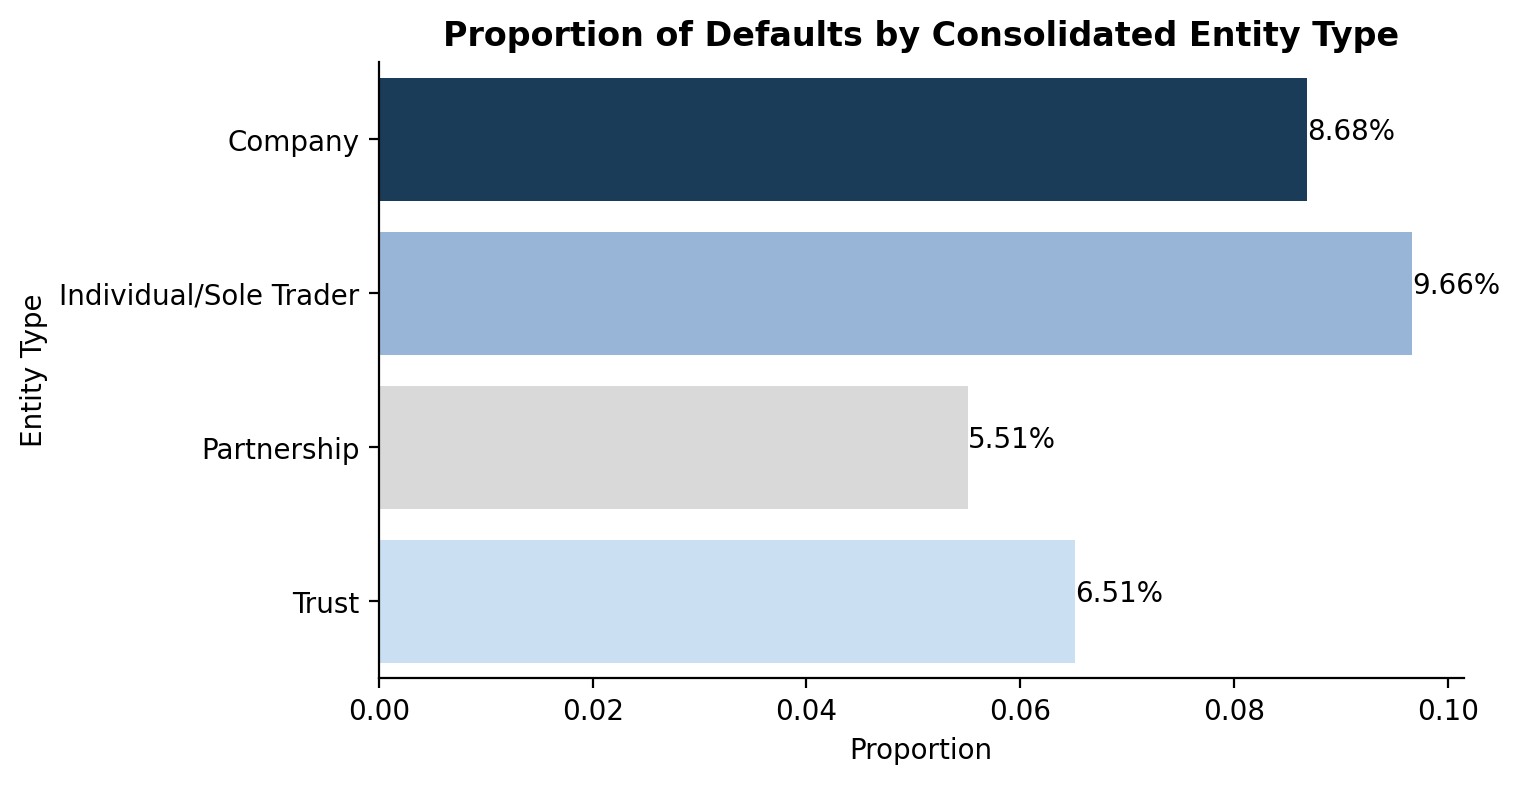

In [ ]:
#plot proportion of defaults by entity_type in chisqdf
default = chisqdf[chisqdf.payment_code=='DEFAULT']['entity_type'].value_counts()
total = chisqdf['entity_type'].value_counts()
proportion = default/total

plt.figure(figsize=(7,4))
sns.barplot(x=proportion.values, y=proportion.index,palette = palette)
#print the portion of defaults by entity type on the right of the bars as percentages
for i in range(len(proportion)):
    plt.text(proportion.values[i], i, str(round(proportion.values[i]*100, 2))+'%', ha = 'left', color = 'black')

plt.title('Proportion of Defaults by Consolidated Entity Type')
plt.xlabel('Proportion')
plt.ylabel('Entity Type')
plt.show()

### Year of Establishment
- Another variable of interest is year of establishment, as companies that are older may be more stable and less likely to default. As seen below the mean years of establishment for default is slightly lower than non-default
-

Shapiro Statistics=0.909, p=0.000


<Figure size 300x300 with 0 Axes>

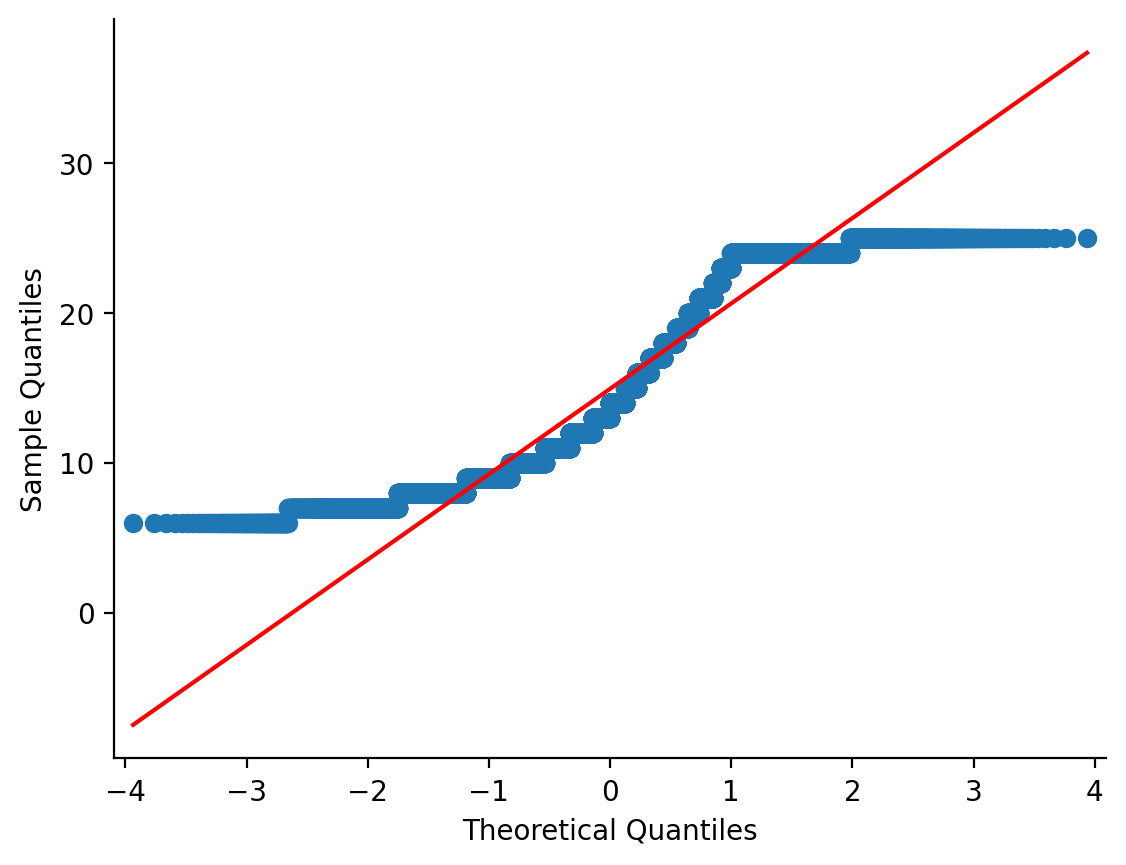

In [ ]:
#qqplot of entity_year_established
stat, p = shapiro(df['entity_year_established'])
print('Shapiro Statistics=%.3f, p=%.3f' % (stat, p))
plt.figure(figsize=(3,3))
qqplot(df['entity_year_established'], line='s')
plt.show()

#### Wilcoxon Rank Sum Test
- To determine whether organizations who defaulted have lower years of establishment, we will compare the years of establishment between default and non-default groups.
- Again, as the data is not normally distributed, we will use the Wilcoxon Rank Sum Test to compare the years of establishment between default and non-default groups.
- Two groups follow similar distributions, as observed from the boxplot
- The test yields a p-value of > 0.05, providing no evidence to reject the null hypothesis that the years of establishment are the same between default and non-default groups.

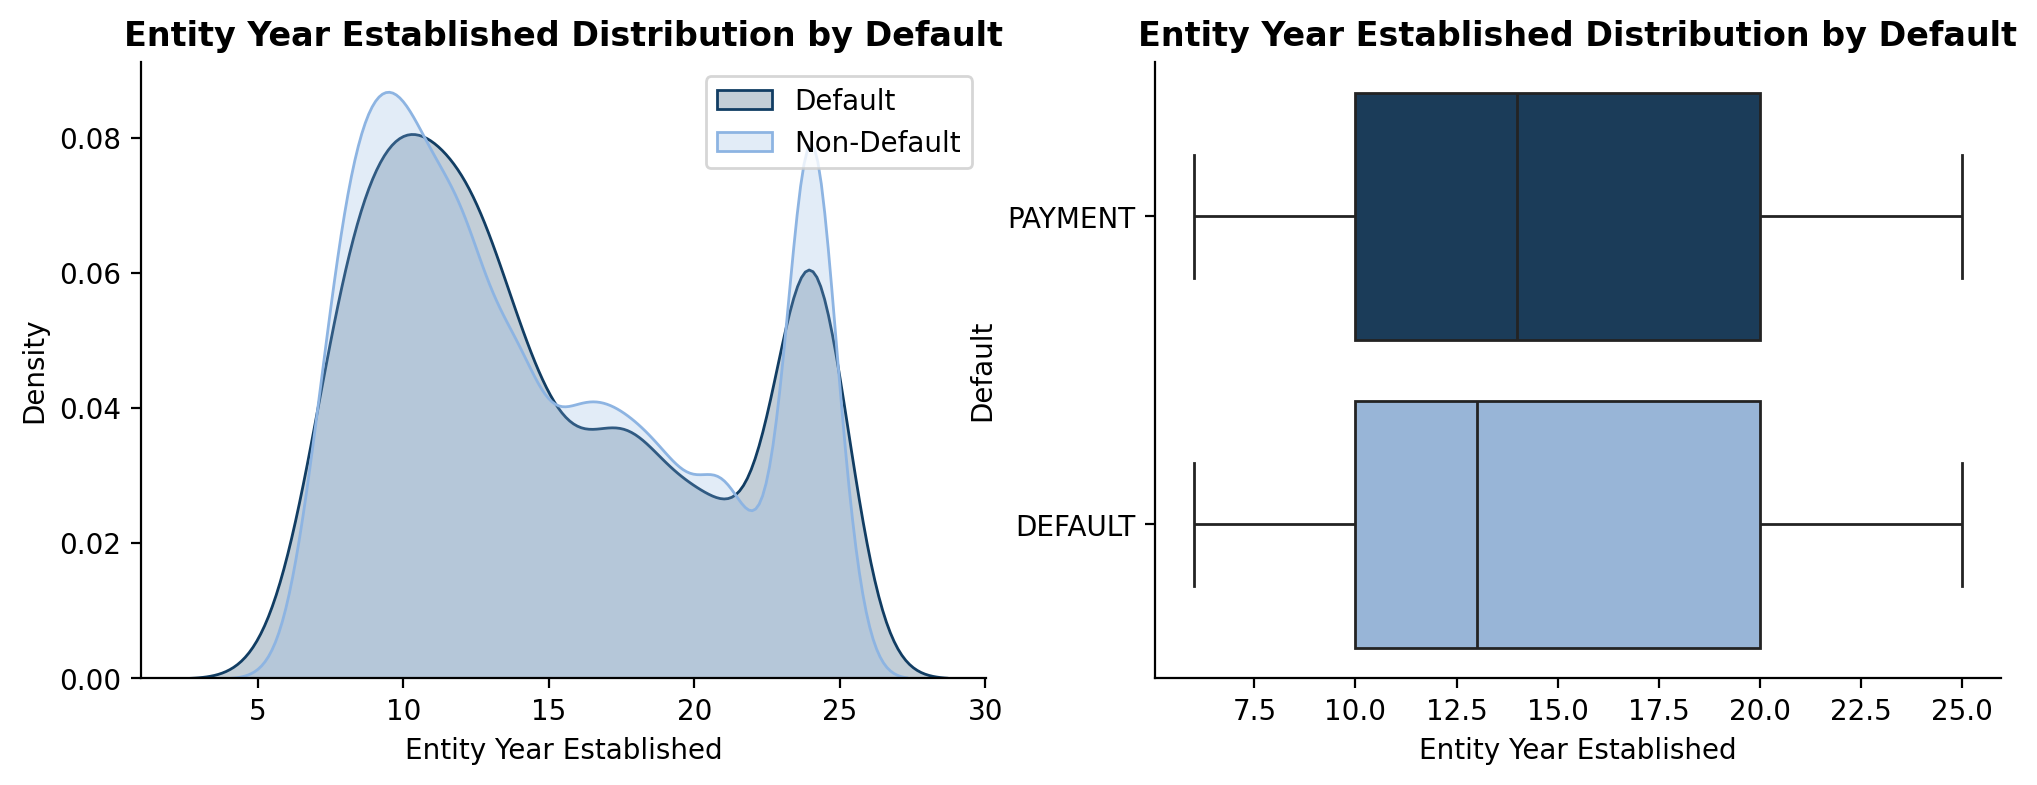

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
default = df[df.payment_code=='DEFAULT']['entity_year_established']
non_default = df[df.payment_code=='PAYMENT']['entity_year_established']

# plot permuted distribution
sns.kdeplot(default, label='Default', color='#113D63', fill=True, ax=axs[0])
sns.kdeplot(non_default, label='Non-Default', color='#8DB4E2', fill=True, ax=axs[0])
axs[0].set_title('Entity Year Established Distribution by Default')
axs[0].set_xlabel('Entity Year Established')
axs[0].set_ylabel('Density')
axs[0].legend()

# plot boxplot
sns.boxplot(x='entity_year_established', y='payment_code', data=df, palette=palette, ax=axs[1])
axs[1].set_title('Entity Year Established Distribution by Default')
axs[1].set_xlabel('Entity Year Established')
axs[1].set_ylabel('Default')
plt.show()


In [ ]:
#calculate mean of entity_year_established for default and non-default payments
df.groupby('payment_code')['entity_year_established'].mean().reset_index()


,payment_code,entity_year_established
0,DEFAULT,14.964552
1,PAYMENT,14.929462


In [ ]:
import numpy as np
from scipy.stats import permutation_test

np.random.seed(0)
default = df[df['payment_code'] == 'DEFAULT']['entity_year_established']
non_default = df[df['payment_code'] == 'PAYMENT']['entity_year_established']

def diff_in_means(x, y):
    return np.mean(x) - np.mean(y)

obs = diff_in_means(default, non_default)
print('Observed Difference:', obs)

test = permutation_test((default, non_default), statistic=diff_in_means, n_resamples=1000)
print('P-value:', test.pvalue)



Observed Difference: 0.035090147243213465
P-value: 0.8511488511488512


## Logistic Regression
- While the above tests gives a better understanding of the relationship among variables, a logistic regression model will be used to predict the probability of default

In [ ]:
df

,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code,entity_type,entity_year_established
0,20175,927,1,2018-05-23 04:08:31,66.66,PAYMENT,Australian Private Company,16
1,8485,927,1,2017-11-27 04:08:15,66.66,PAYMENT,Australian Private Company,16
2,13778,927,1,2018-02-23 04:08:23,66.66,PAYMENT,Australian Private Company,16
3,22768,927,1,2018-06-25 04:08:44,66.66,PAYMENT,Australian Private Company,16
4,15698,927,1,2018-03-23 04:08:24,66.66,PAYMENT,Australian Private Company,16
...,...,...,...,...,...,...,...,...
25550,25386,1608,1279,2018-07-23 04:08:13,325.00,PAYMENT,Australian Private Company,8
25554,25075,1603,1280,2018-07-20 04:09:24,1666.68,PAYMENT,Family Partnership,24
25555,24711,1603,1280,2018-07-17 04:09:20,0.01,PAYMENT,Family Partnership,24
25556,25076,1603,1280,2018-07-20 04:09:24,64.99,PAYMENT,Family Partnership,24


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24118 entries, 0 to 25557
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           24118 non-null  int64         
 1   contract_id              24118 non-null  int64         
 2   client_id                24118 non-null  int64         
 3   transaction_date         24118 non-null  datetime64[ns]
 4   payment_amt              24118 non-null  float64       
 5   payment_code             24118 non-null  object        
 6   entity_type              24118 non-null  object        
 7   entity_year_established  24118 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), object(2)
memory usage: 2.1+ MB


In [ ]:
y

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
25550   NaN
25554   NaN
25555   NaN
25556   NaN
25557   NaN
Name: payment_code, Length: 24118, dtype: float64

In [ ]:
df.pad

In [ ]:
df['payment_code'] = df['payment_code'].map({'DEFAULT': 0, 'PAYMENT': 1})

X = df.drop(['payment_code', 'transaction_id','client_id','transaction_date'], axis=1)
y = df['payment_code']

# Convert only the predictors (not the target variable) to dummy variables
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = LogisticRegression()
sfs = SFS(model, k_features=3, forward=True, floating=False, scoring='accuracy', cv=0)
sfs.fit(X_train, y_train)

print(sfs.k_feature_names_)

ValueError: Input y contains NaN.